# Customer Segmentation 

By:   M V Nikhitha

## Importing the libraries

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import plotly.graph_objs as go
import plotly.offline as pyo

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline

In [2]:
df = pd.read_csv("./data/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
print(f"Number of Rows: {df.shape[0]}\nNumber of Columns: {df.shape[1]}")

Number of Rows: 200
Number of Columns: 5


## Exploratory Data Analysis (EDA)

In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [6]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

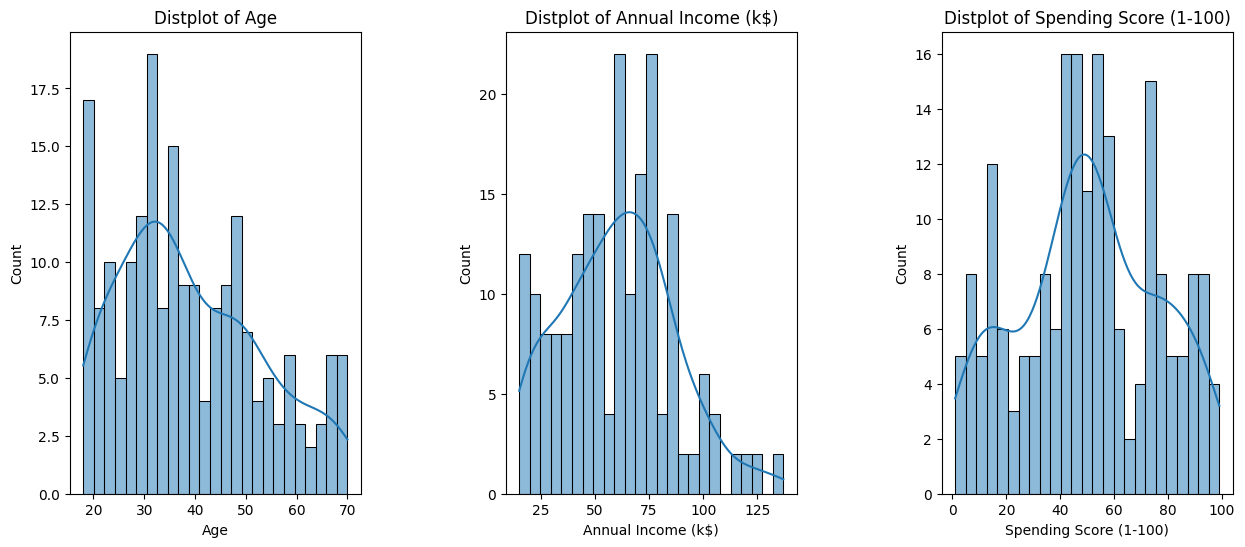

In [7]:
plt.figure(1, figsize=(15, 6))
n = 0
for x in list(df.columns[2:]):
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.histplot(data=df[x], bins=25, kde=True)
    plt.title(f"Distplot of {x}")
plt.show()

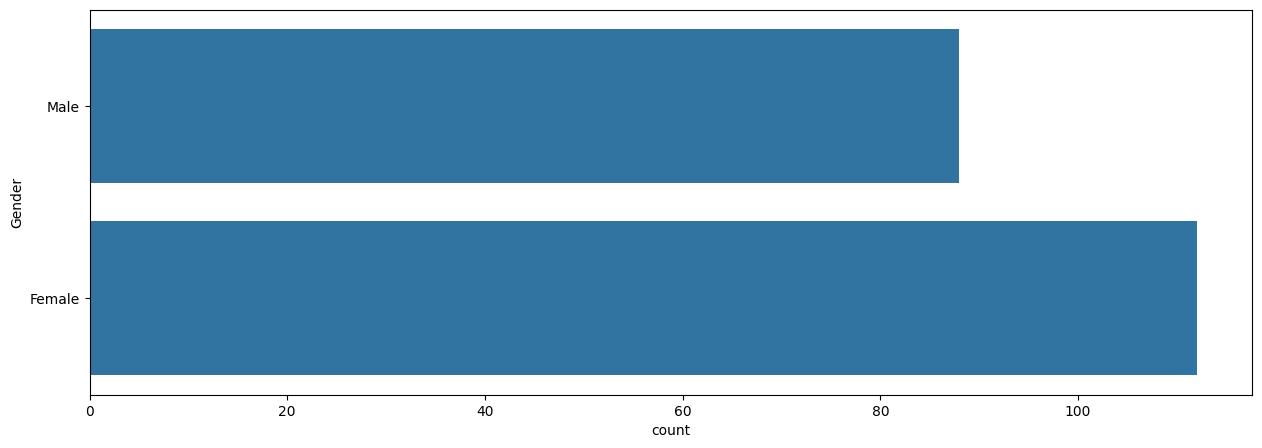

In [8]:
plt.figure(1, figsize=(15, 5))
sns.countplot(y="Gender", data=df)
plt.show()

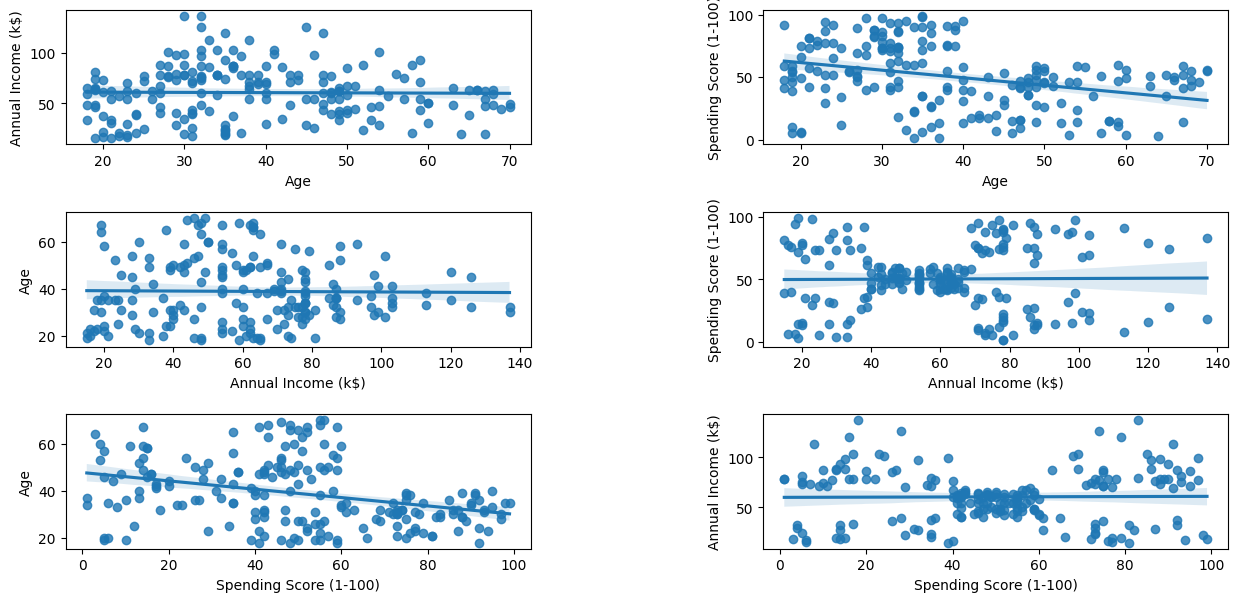

In [9]:
plt.figure(1, figsize=(15, 7))
n = 0 
for x in list(df.columns[2:]):
    for y in list(df.columns[2:]):
        if x == y: continue
        n += 1
        plt.subplot(3, 2, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        sns.regplot(x=x, y=y, data=df)
        plt.ylabel(y)
plt.show()

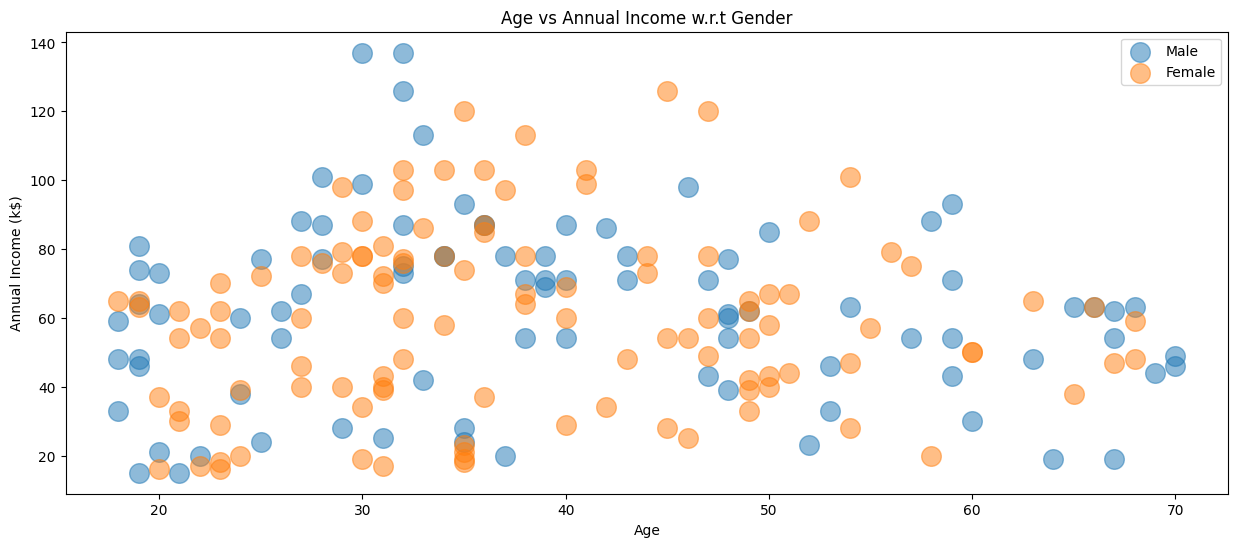

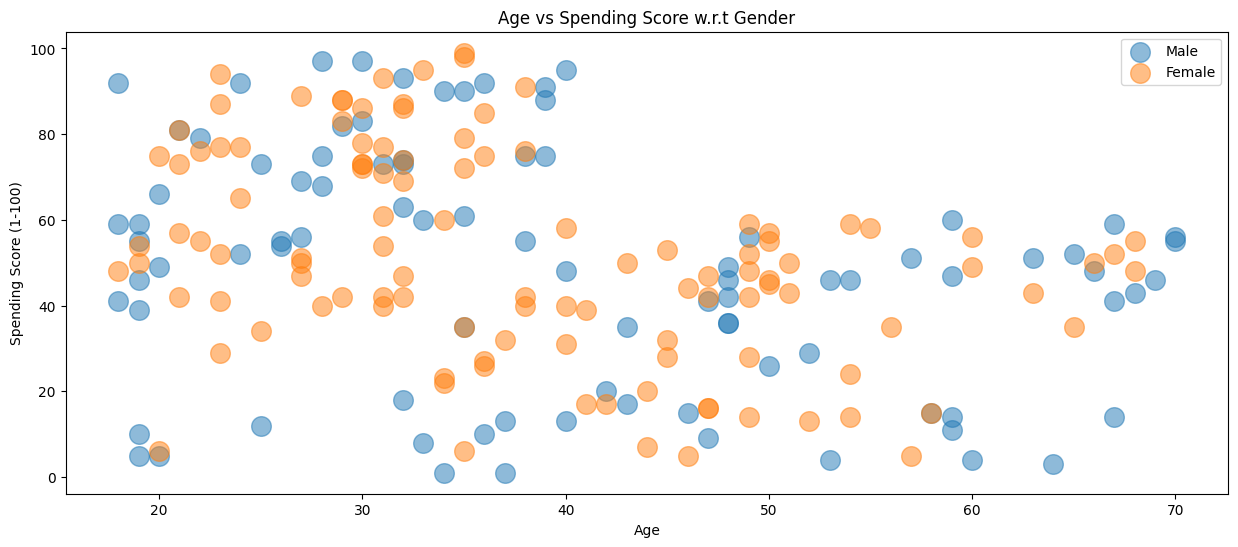

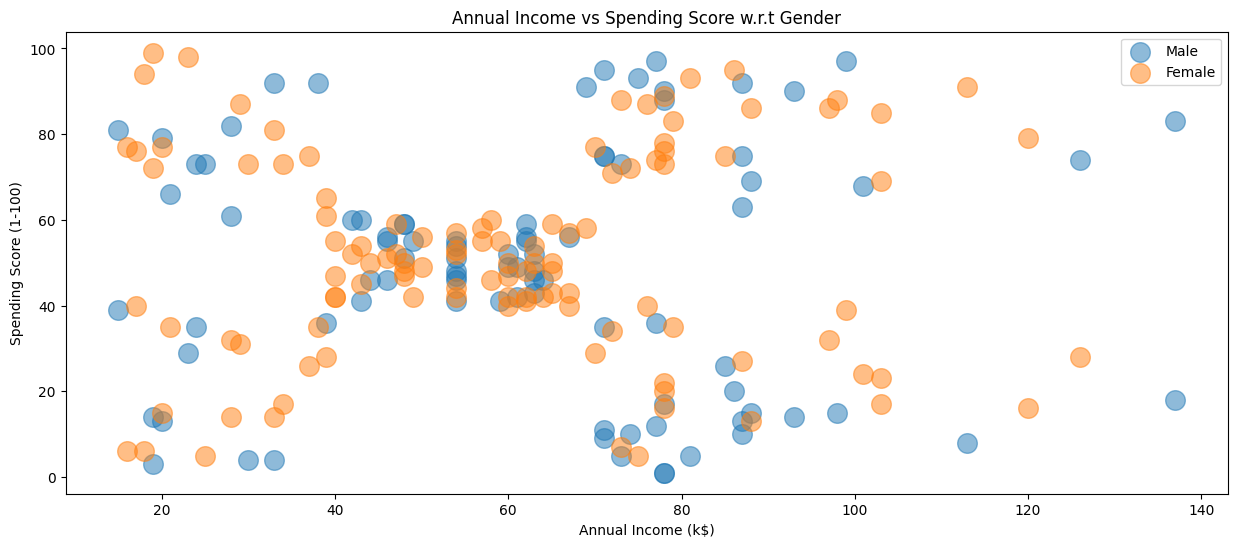

In [10]:
def scatter_plot(x, y, title):
    plt.figure(figsize=(15, 6))
    for gender in df["Gender"].unique():
        plt.scatter(x=df[df["Gender"] == gender][x], y=df[df["Gender"] == gender][y], s=200, alpha=0.5, label=gender)
    plt.title(f"{title} w.r.t Gender")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()

scatter_plot("Age", "Annual Income (k$)", "Age vs Annual Income")
scatter_plot("Age", "Spending Score (1-100)", "Age vs Spending Score")
scatter_plot("Annual Income (k$)", "Spending Score (1-100)", "Annual Income vs Spending Score")


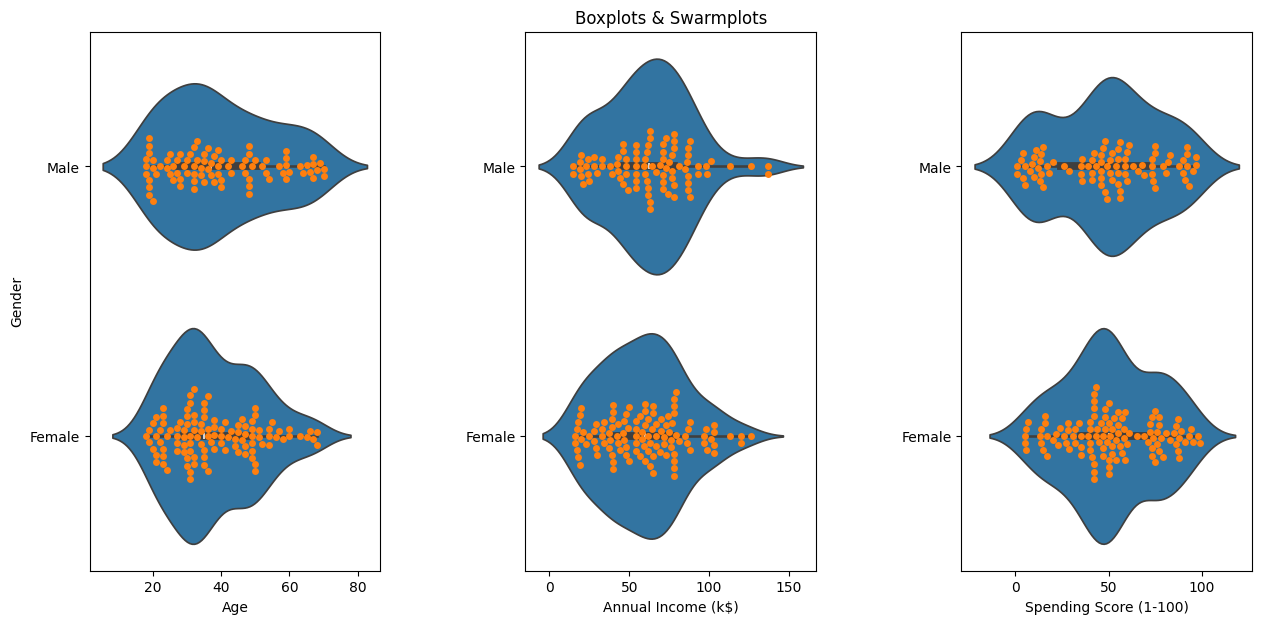

In [11]:
plt.figure(1, figsize=(15, 7))
n = 0
for cols in list(df.columns[2:]):
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.violinplot(x=cols, y="Gender", data=df)
    sns.swarmplot(x=cols, y="Gender", data=df)
    plt.ylabel("Gender" if n == 1 else '')
    plt.title("Boxplots & Swarmplots" if n == 2 else '')
plt.show()

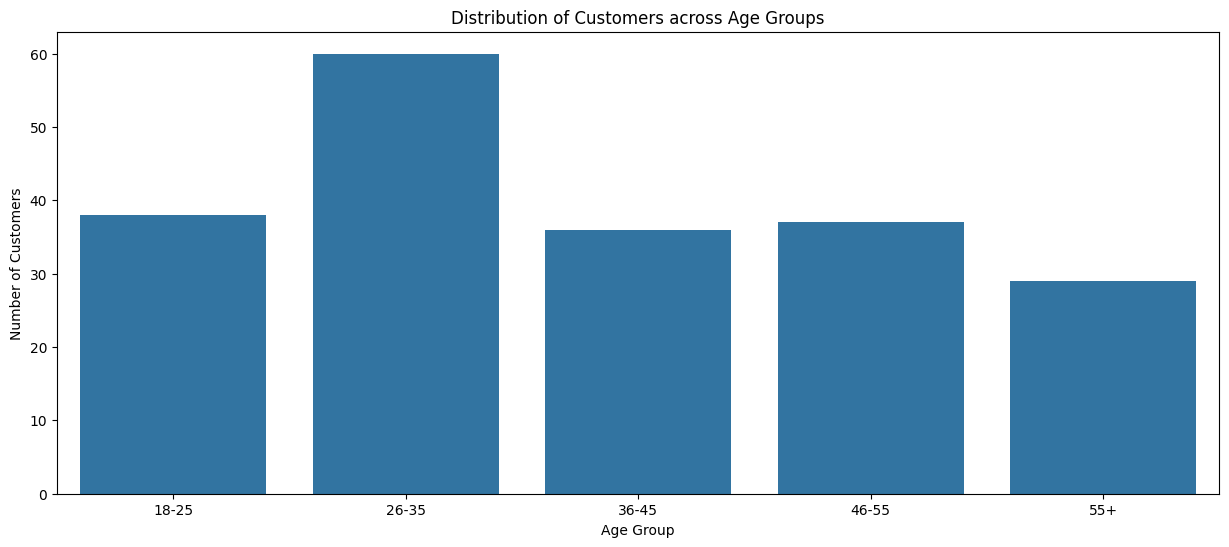

In [12]:
age_groups = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, np.inf], labels=['18-25', '26-35', '36-45', '46-55', '55+'])
df_copy = df.copy()
df_copy['Age Group'] = age_groups

plt.figure(figsize=(15, 6))
sns.countplot(x='Age Group', data=df_copy)
plt.title('Distribution of Customers across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.show()

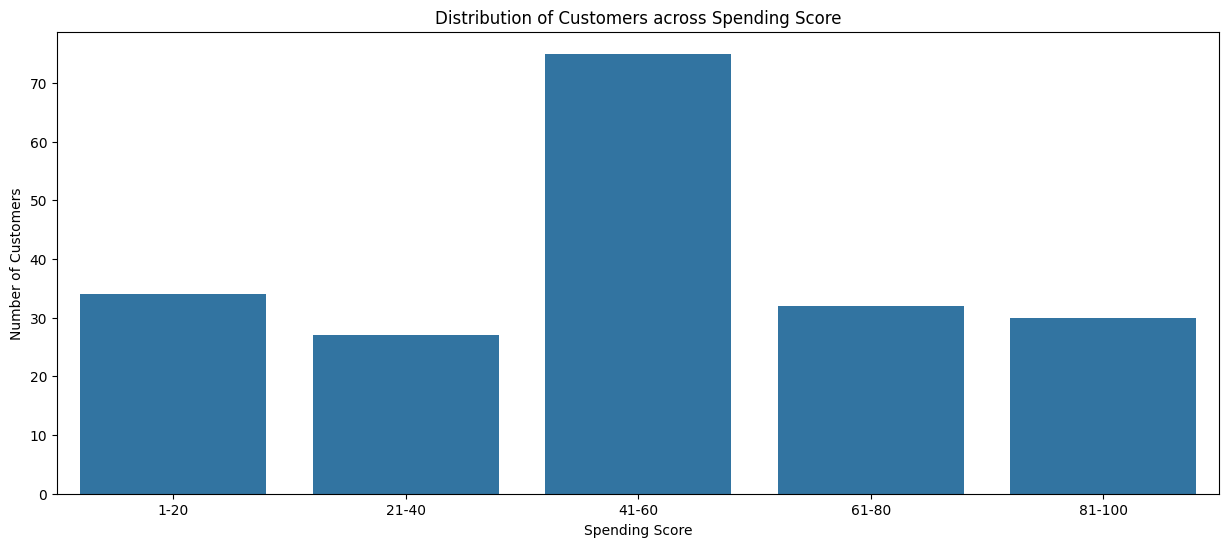

In [13]:
spending_groups = pd.cut(df['Spending Score (1-100)'], bins=[1, 20, 40, 60, 80, 100], labels=['1-20', '21-40', '41-60', '61-80', '81-100'])
df_copy = df.copy()
df_copy['Spending Group'] = spending_groups
plt.figure(figsize=(15, 6))
sns.countplot(x='Spending Group', data=df_copy)
plt.title('Distribution of Customers across Spending Score')
plt.xlabel('Spending Score')
plt.ylabel('Number of Customers')
plt.show()

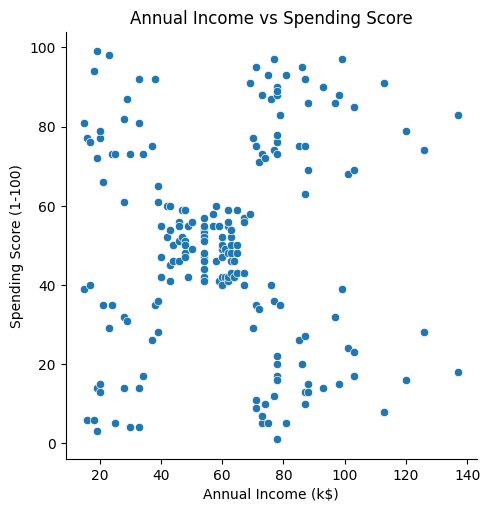

In [14]:
sns.relplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df)
plt.title('Annual Income vs Spending Score')
plt.show()

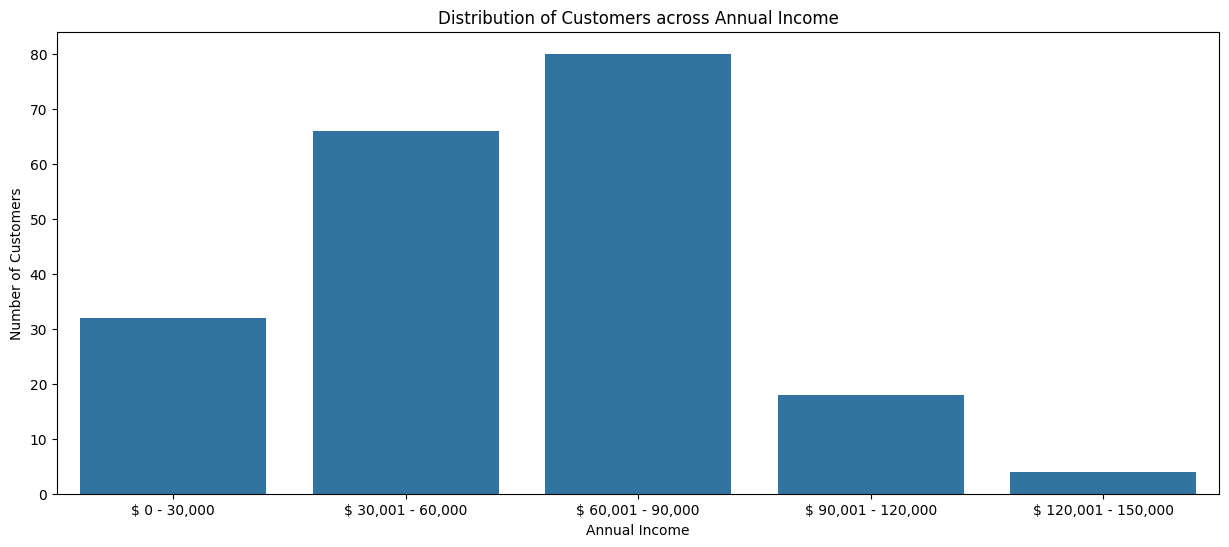

In [15]:
income_groups = pd.cut(df['Annual Income (k$)'], bins=[0, 30, 60, 90, 120, 150], labels=['$ 0 - 30,000', '$ 30,001 - 60,000', '$ 60,001 - 90,000', '$ 90,001 - 120,000', '$ 120,001 - 150,000'])
df_copy = df.copy()
df_copy['Income Group'] = income_groups
plt.figure(figsize=(15, 6))
sns.countplot(x='Income Group', data=df_copy)
plt.title('Distribution of Customers across Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Number of Customers')
plt.show()

In [16]:
def silhouette_analysis(X, x, y):
    for n_clusters in list(range(2,8)):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The silhouette coefficient can range from [-1, 1] but in this scenerio all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, max_iter=300, tol=0.0001, random_state=0, algorithm="elkan")
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10

        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]

            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        centers = clusterer.cluster_centers_

        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel(x)
        ax2.set_ylabel(y)

        plt.suptitle(
            f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

def visualize_segmentation(X, n_clusters, x, y):
    algorithm = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, max_iter=300, tol=0.0001, random_state=0, algorithm="elkan")
    algorithm.fit(X)
    labels = algorithm.labels_ + 1
    centroids = algorithm.cluster_centers_

    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(1, figsize=(15, 7))
    plt.clf()
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation="nearest",
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Pastel2, aspect="auto", origin="lower")

    scatter = plt.scatter(x=X[:, 0], y=X[:, 1], c=labels, s=200)
    plt.scatter(x=centroids[:, 0], y=centroids[:, 1], s=300, c="red", alpha=0.5)

    plt.ylabel(y)
    plt.xlabel(x)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()


#### Segmentation using Age and Annual Income

For n_clusters = 2 The average silhouette_score is : 0.42620850066216065
For n_clusters = 3 The average silhouette_score is : 0.4254725038202792
For n_clusters = 4 The average silhouette_score is : 0.43295184273333076
For n_clusters = 5 The average silhouette_score is : 0.40157587536205724
For n_clusters = 6 The average silhouette_score is : 0.3957929992385571
For n_clusters = 7 The average silhouette_score is : 0.3818741232018279


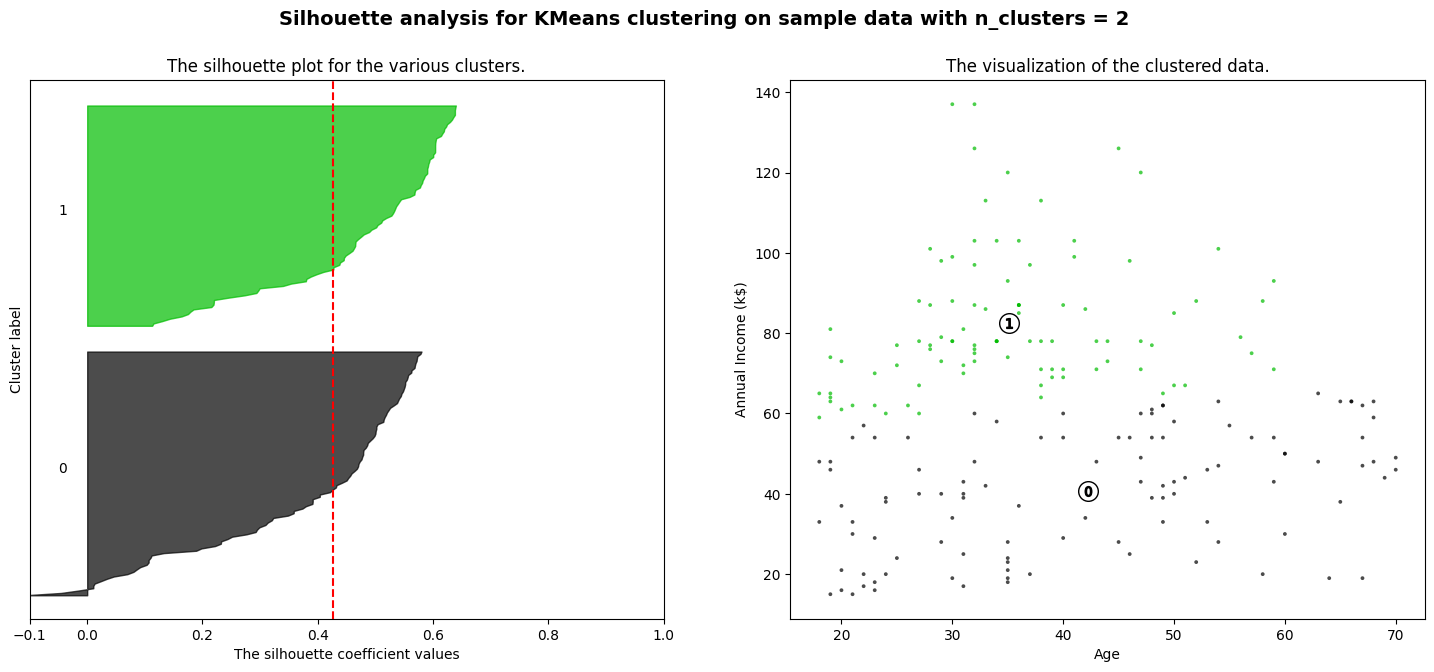

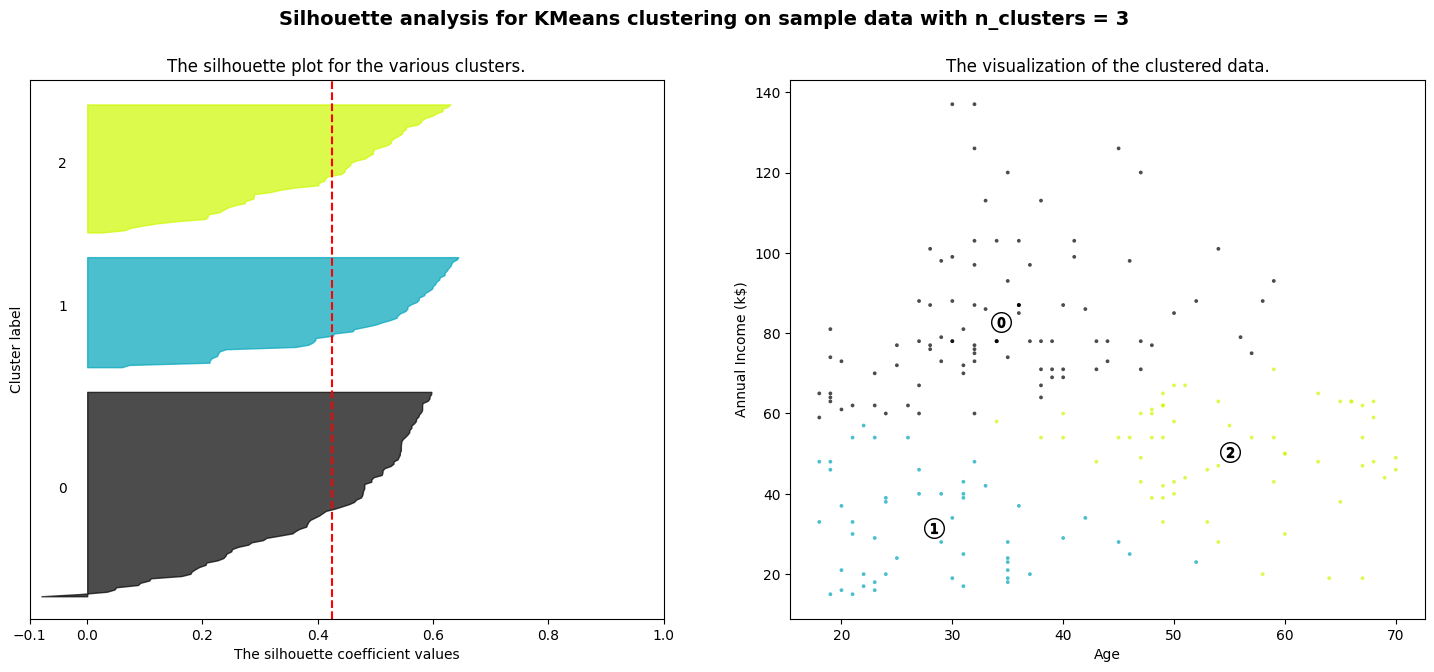

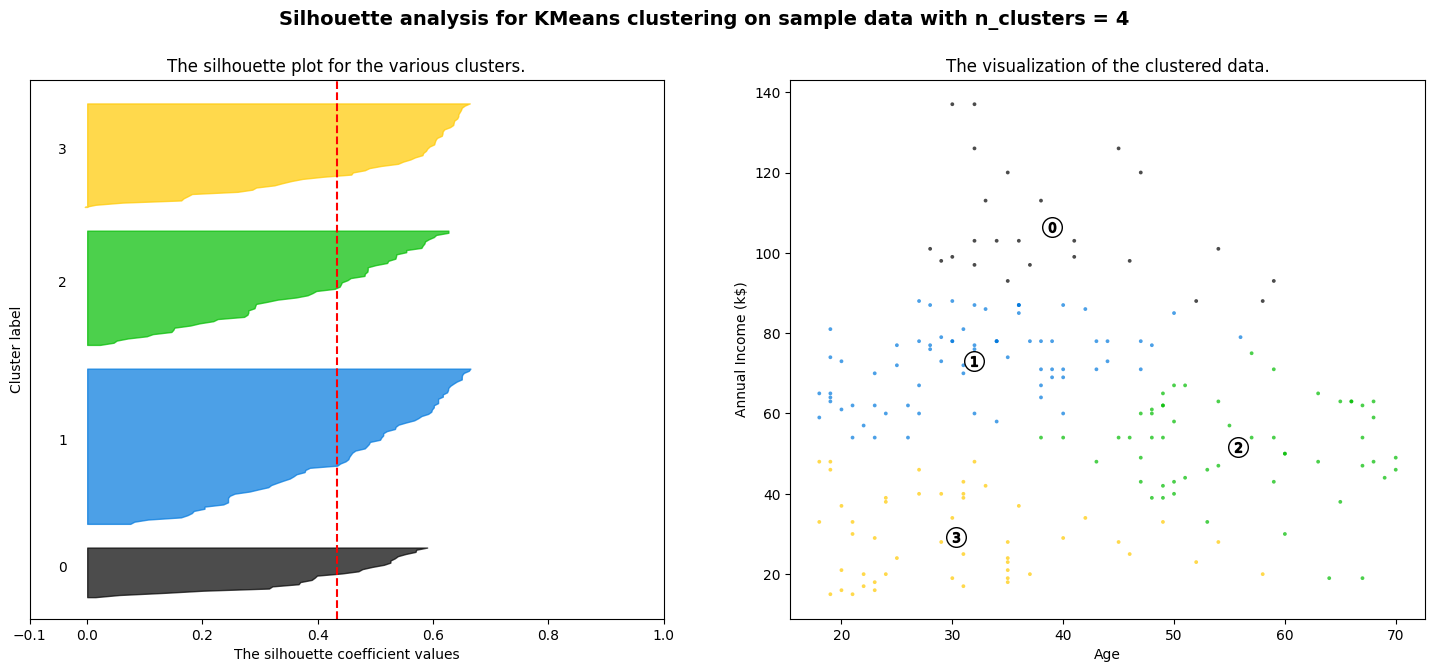

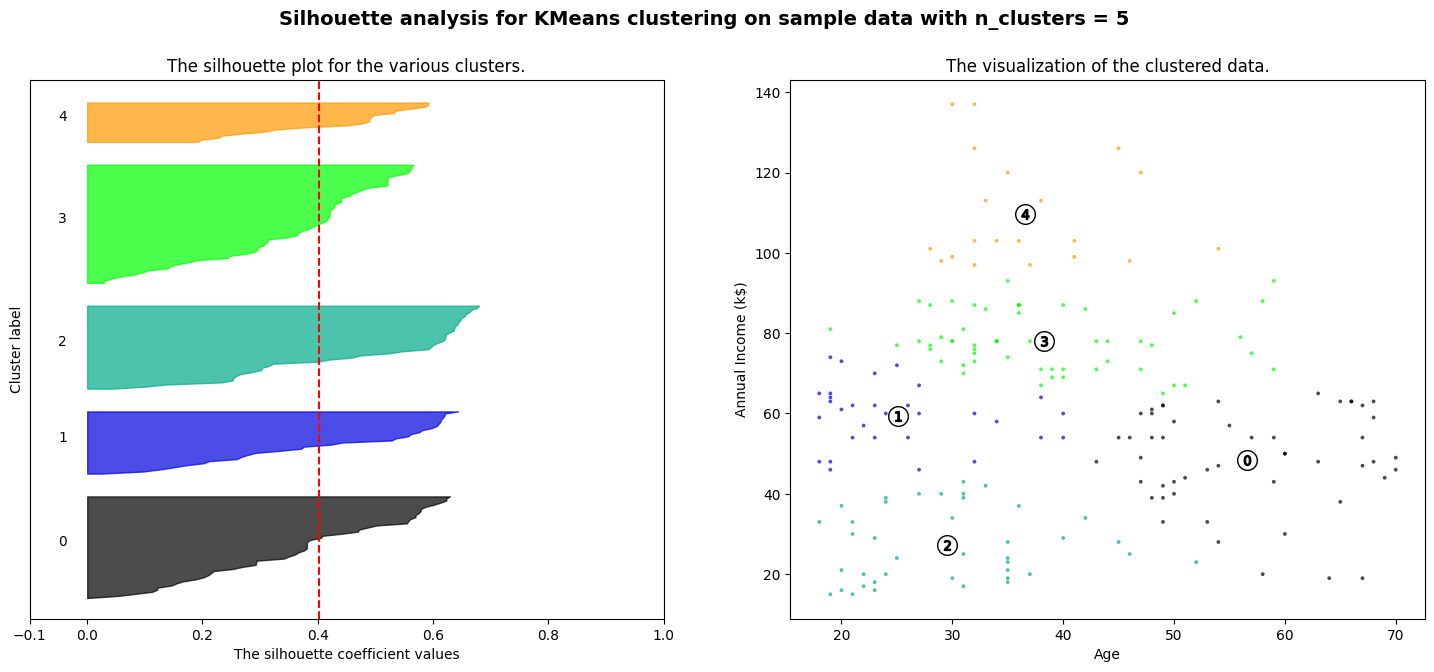

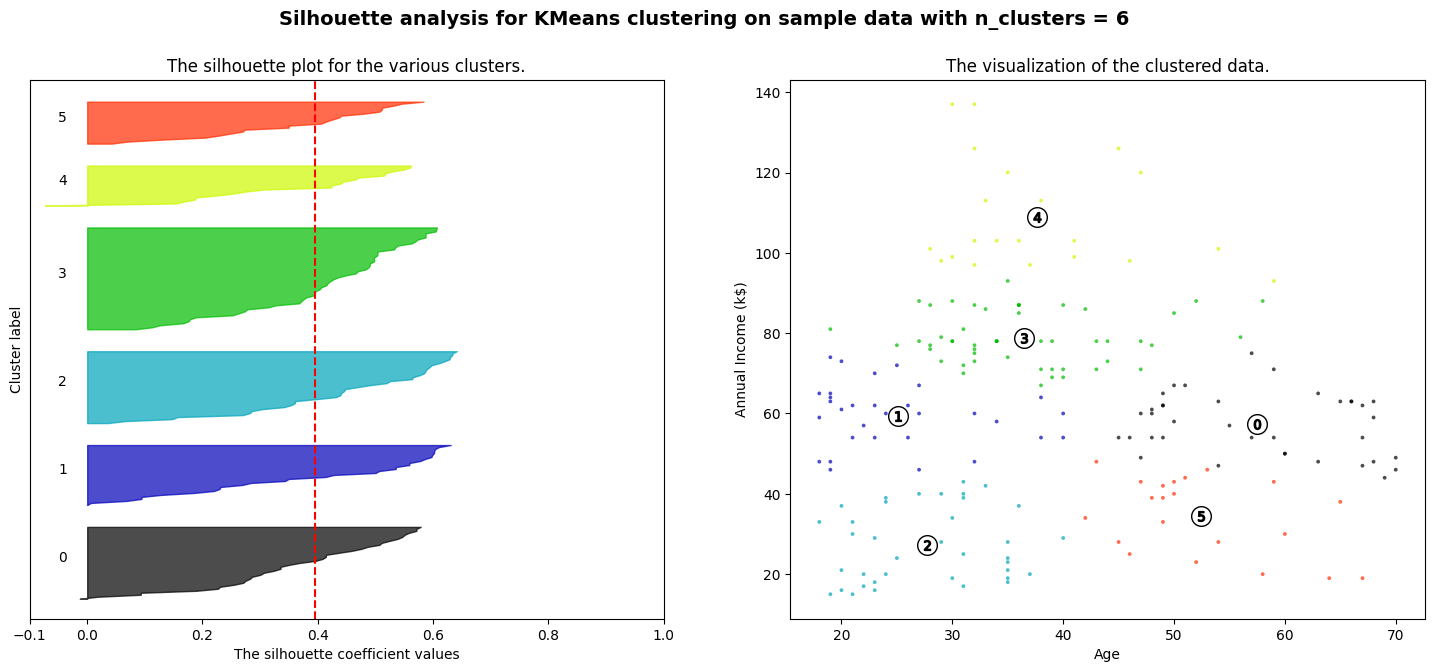

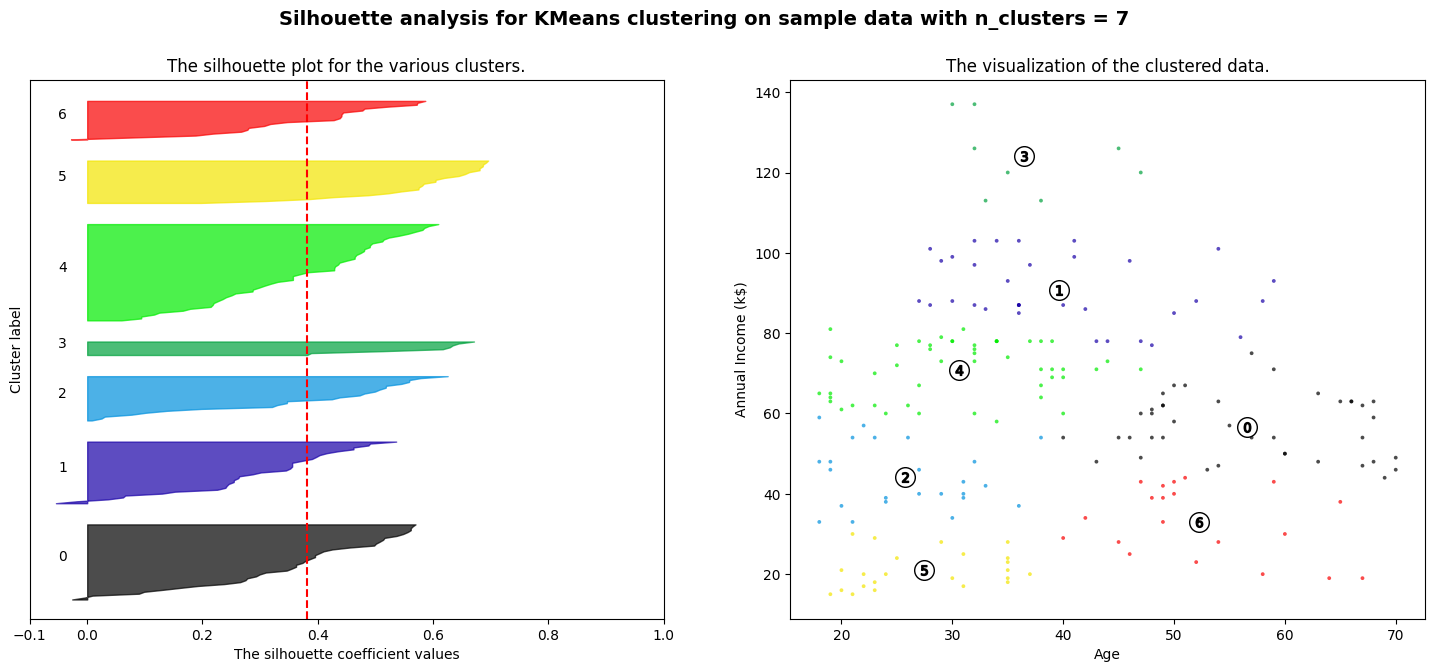

In [17]:
X = df[["Age", "Annual Income (k$)"]].values
silhouette_analysis(X, "Age", "Annual Income (k$)")

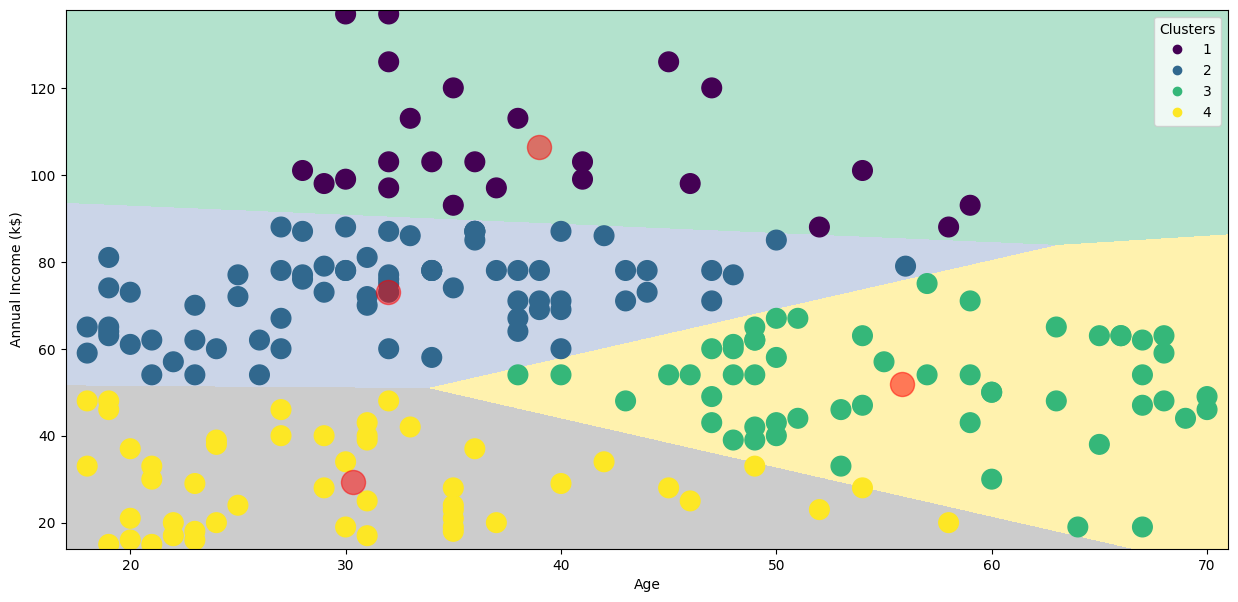

In [18]:
visualize_segmentation(X, 4, "Age", "Annual Income (k$)")

#### Segmentation using Age and Spending Score

For n_clusters = 2 The average silhouette_score is : 0.4692341232501655
For n_clusters = 3 The average silhouette_score is : 0.45300127016521263
For n_clusters = 4 The average silhouette_score is : 0.49973941540141753
For n_clusters = 5 The average silhouette_score is : 0.44526667994351227
For n_clusters = 6 The average silhouette_score is : 0.446619017091555
For n_clusters = 7 The average silhouette_score is : 0.42313509747504796


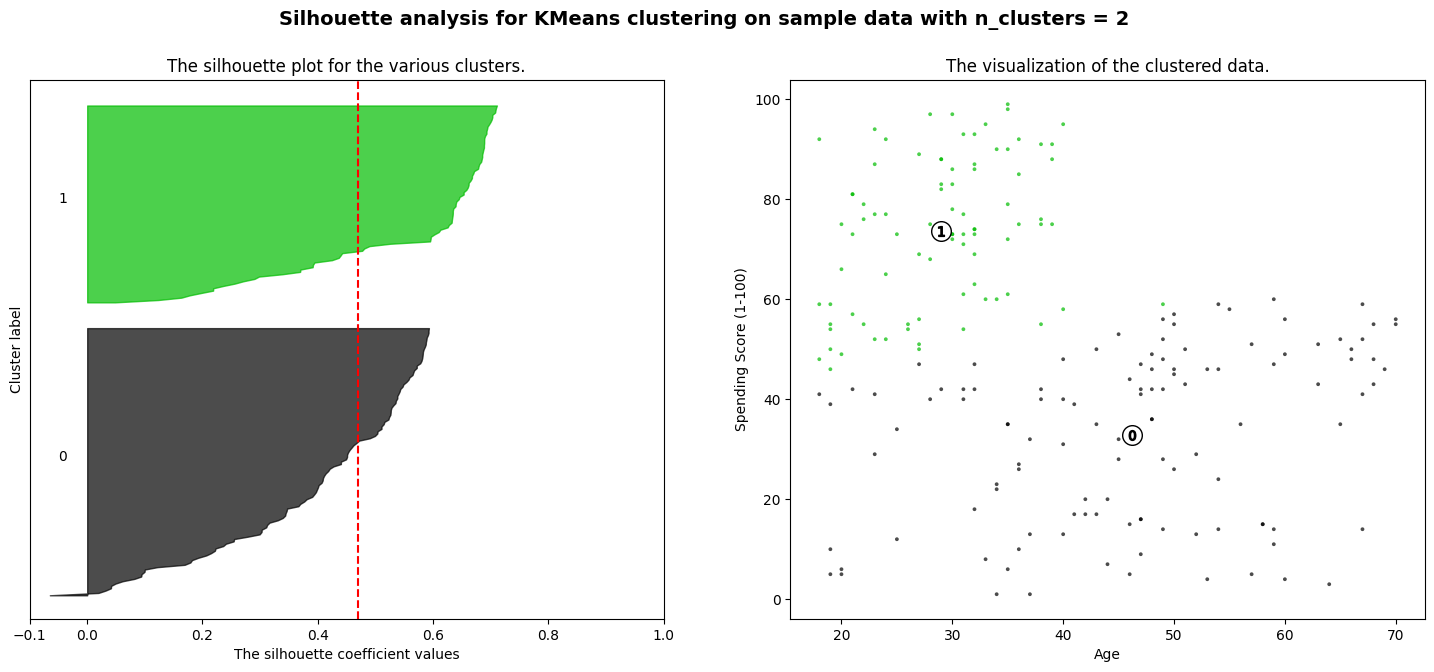

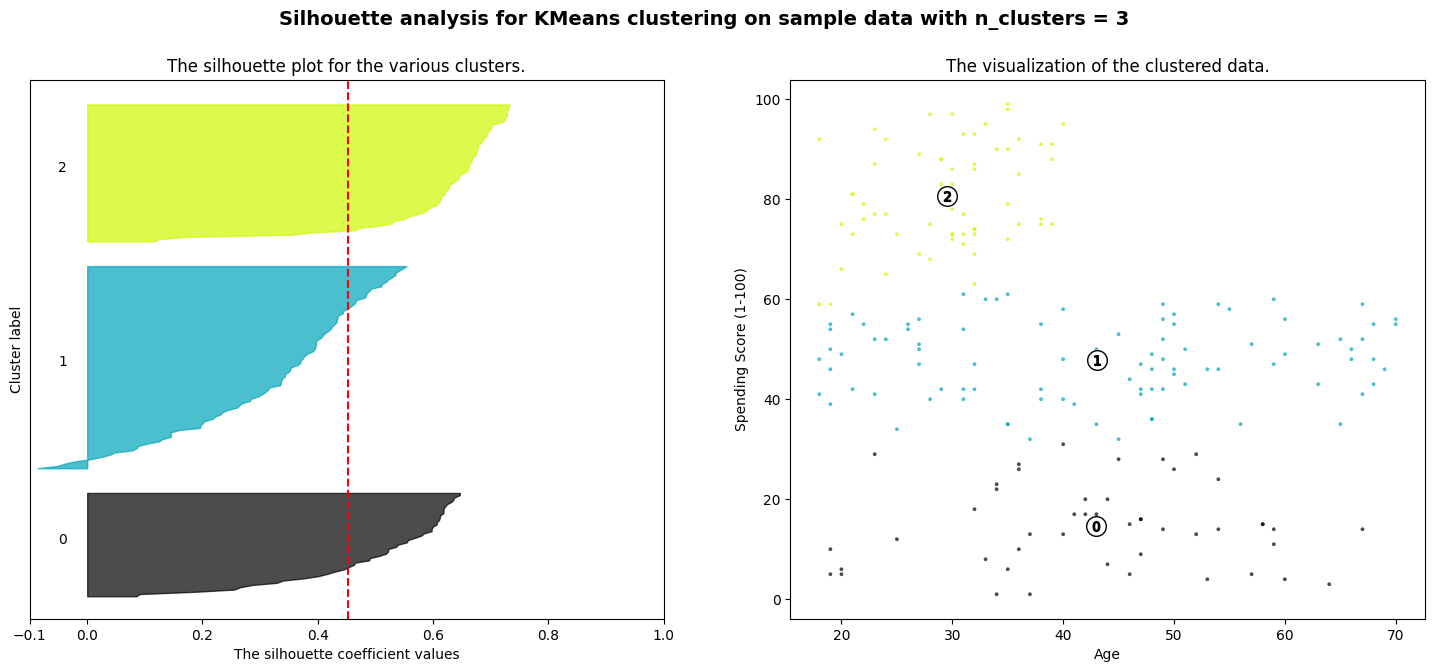

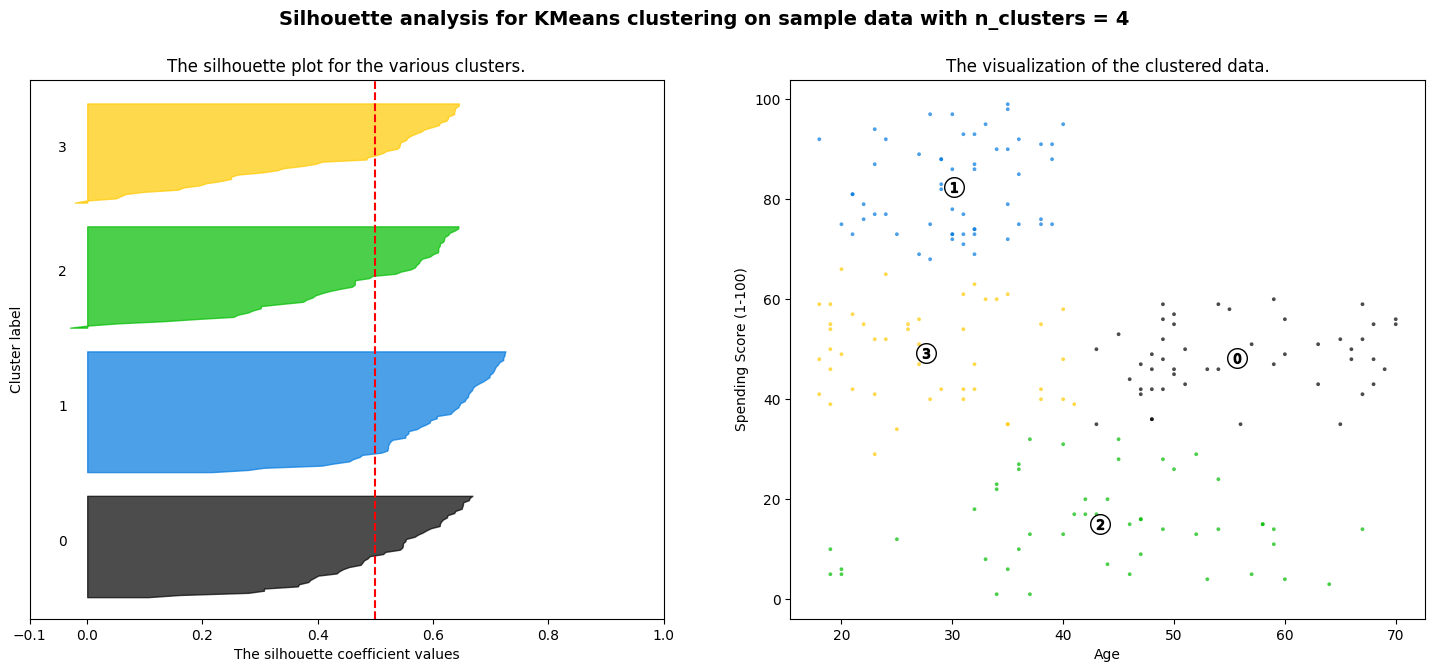

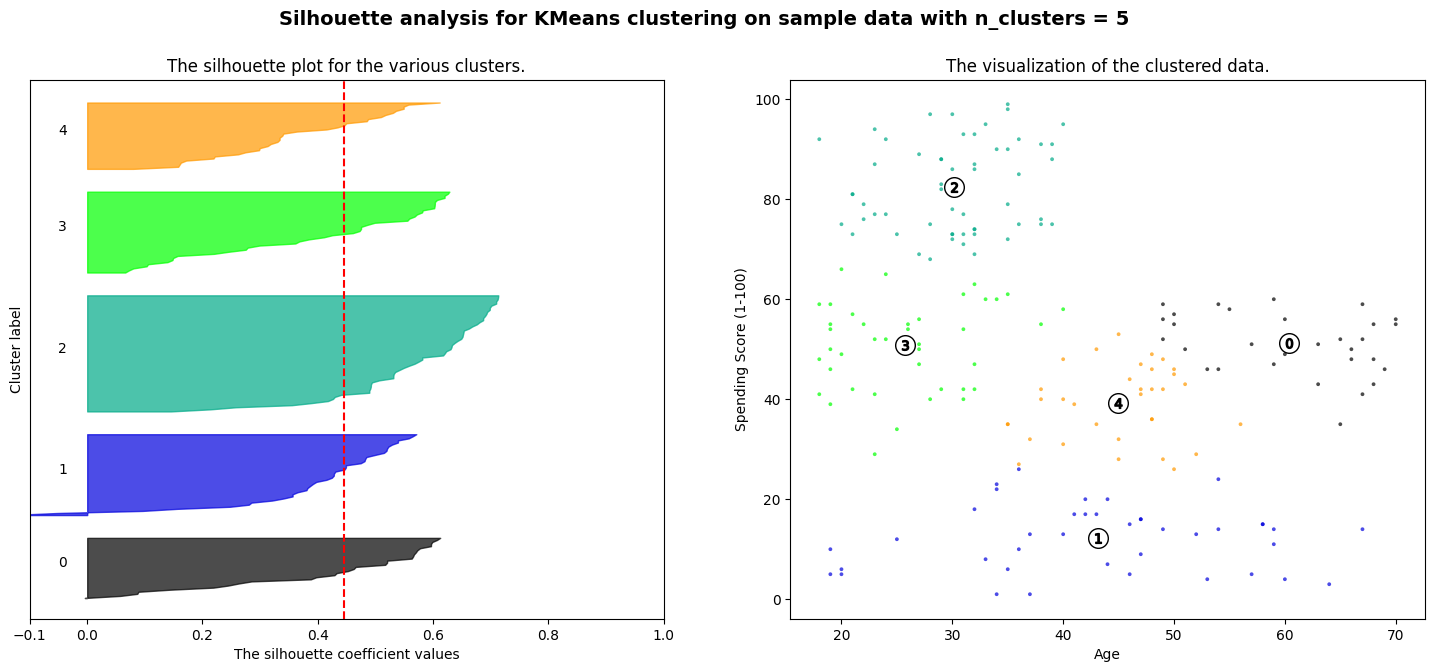

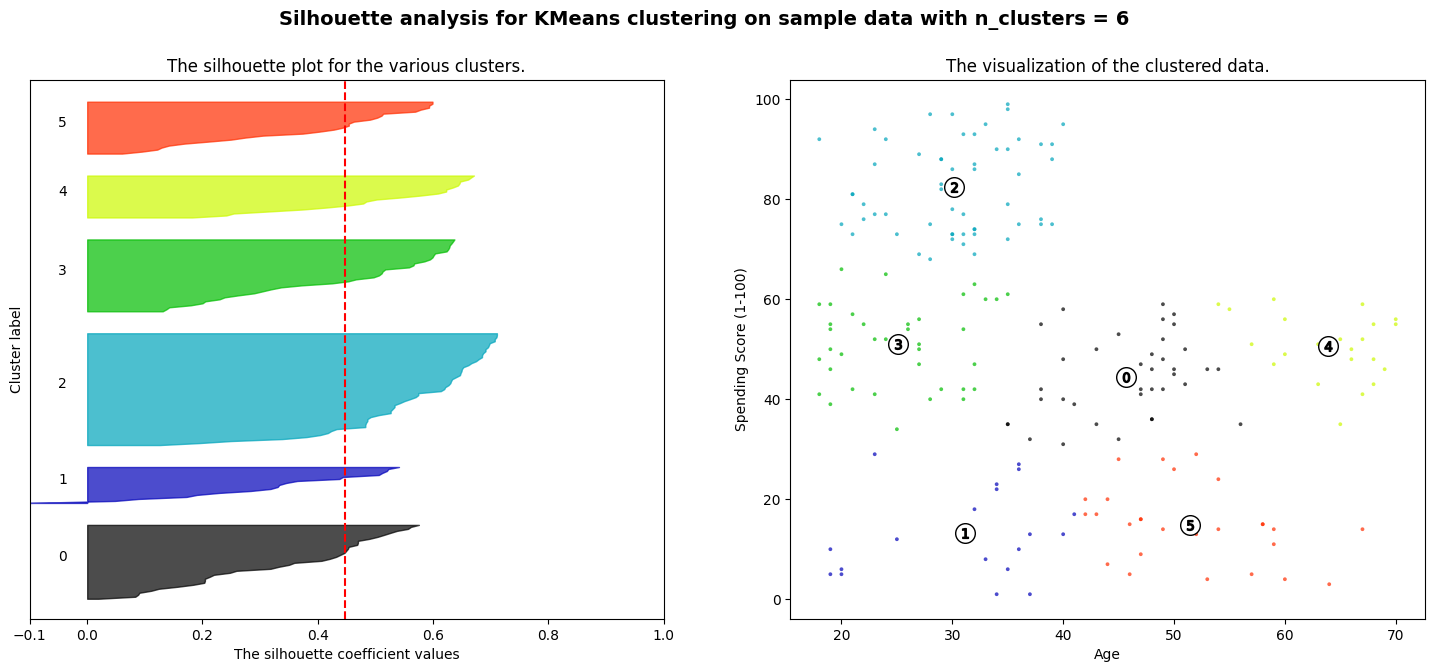

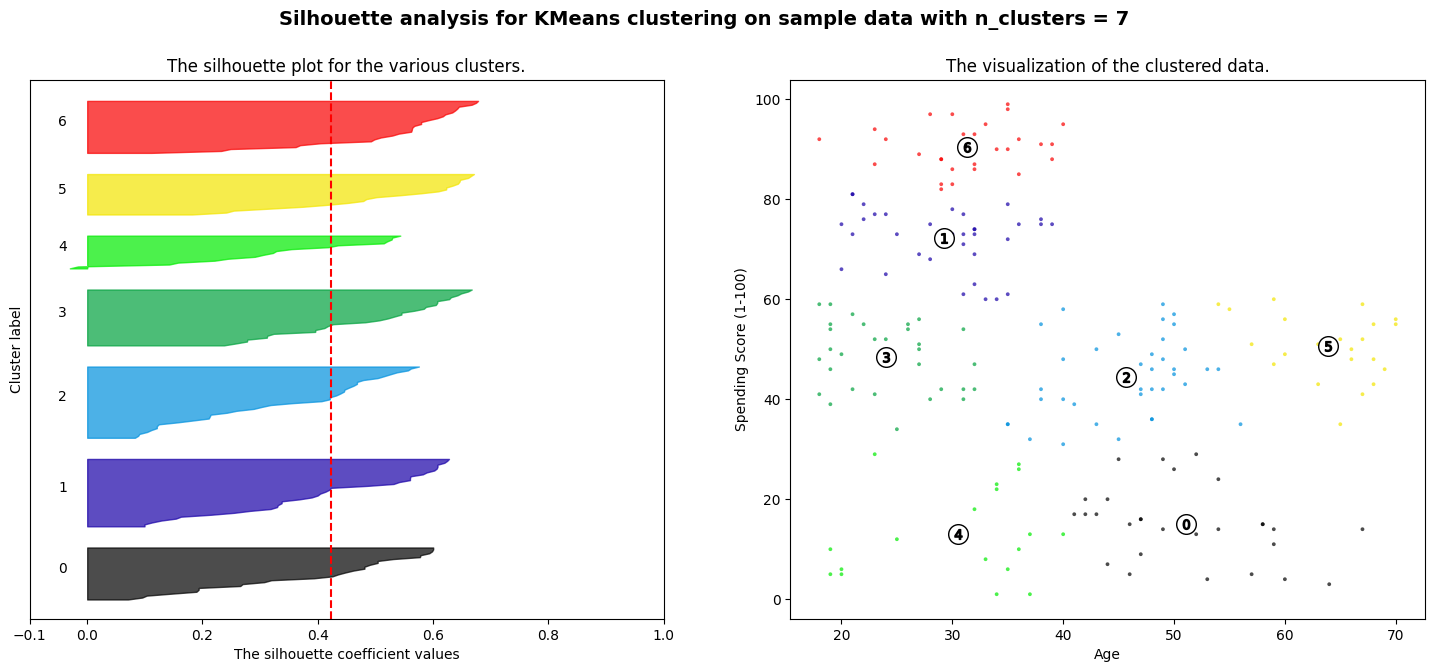

In [19]:
X = df[["Age", "Spending Score (1-100)"]].values
silhouette_analysis(X, "Age", "Spending Score (1-100)")

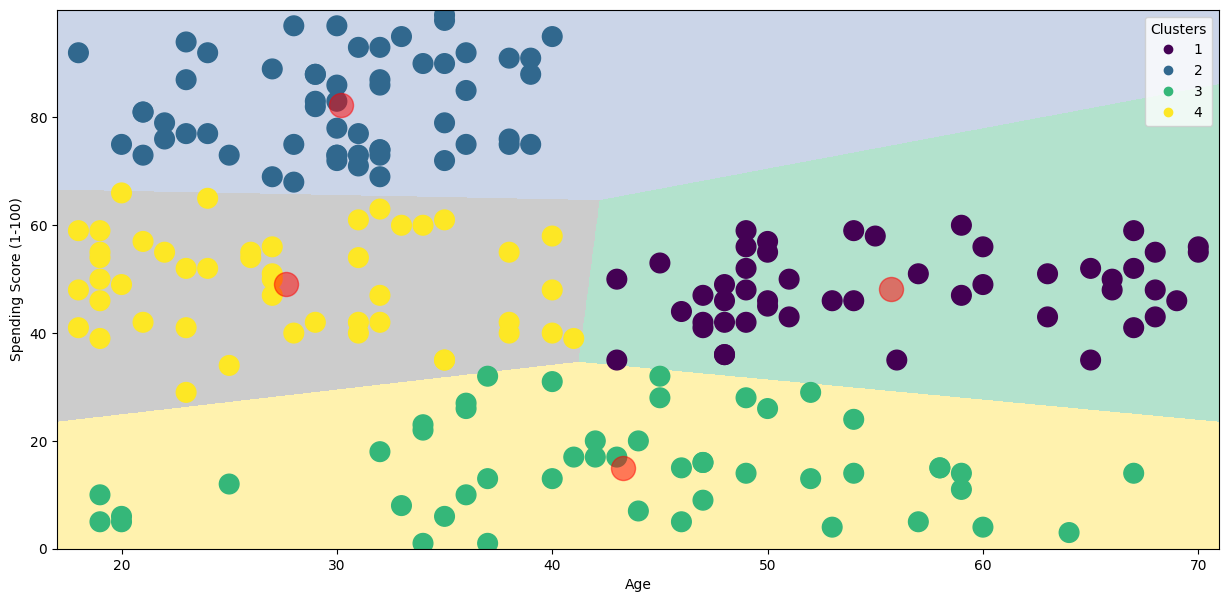

In [20]:
visualize_segmentation(X, 4, "Age", "Spending Score (1-100)")

#### Segmentation using Annual Income and Spending Score

For n_clusters = 2 The average silhouette_score is : 0.2968969162503008
For n_clusters = 3 The average silhouette_score is : 0.46761358158775435
For n_clusters = 4 The average silhouette_score is : 0.4931963109249047
For n_clusters = 5 The average silhouette_score is : 0.553931997444648
For n_clusters = 6 The average silhouette_score is : 0.5379675585622219
For n_clusters = 7 The average silhouette_score is : 0.5264283703685728


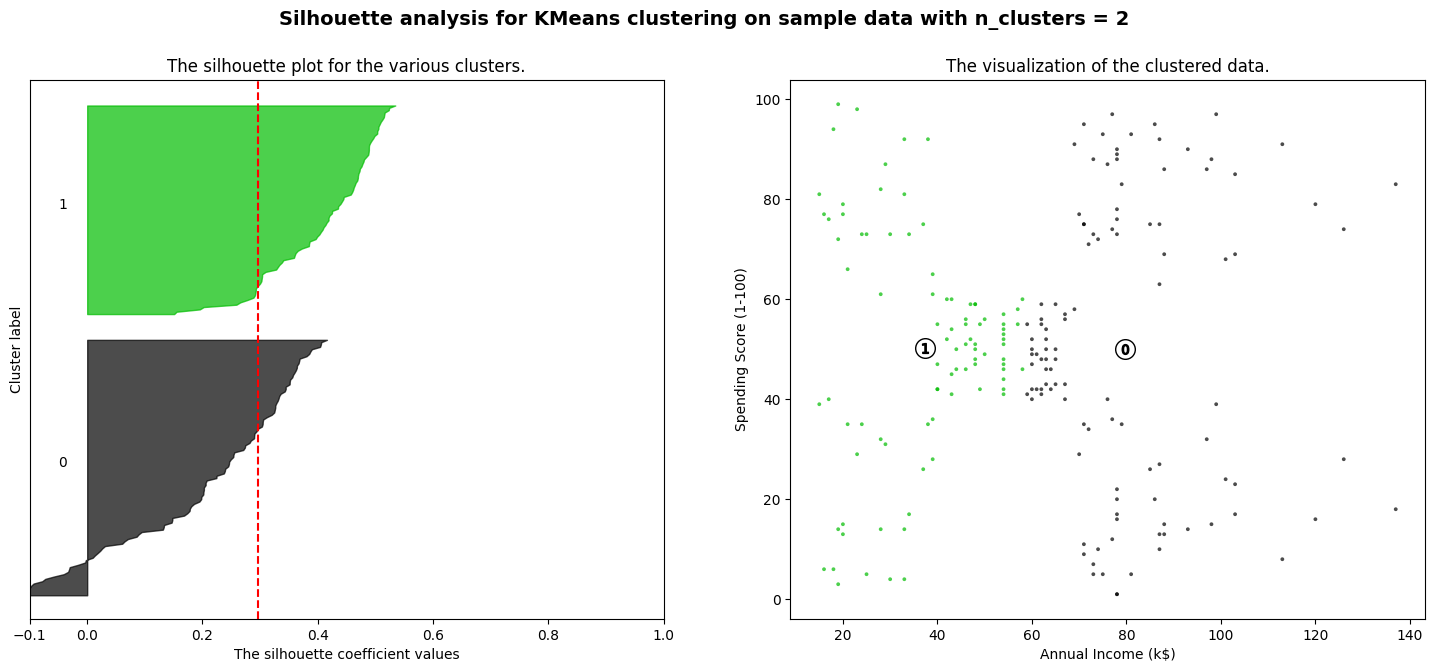

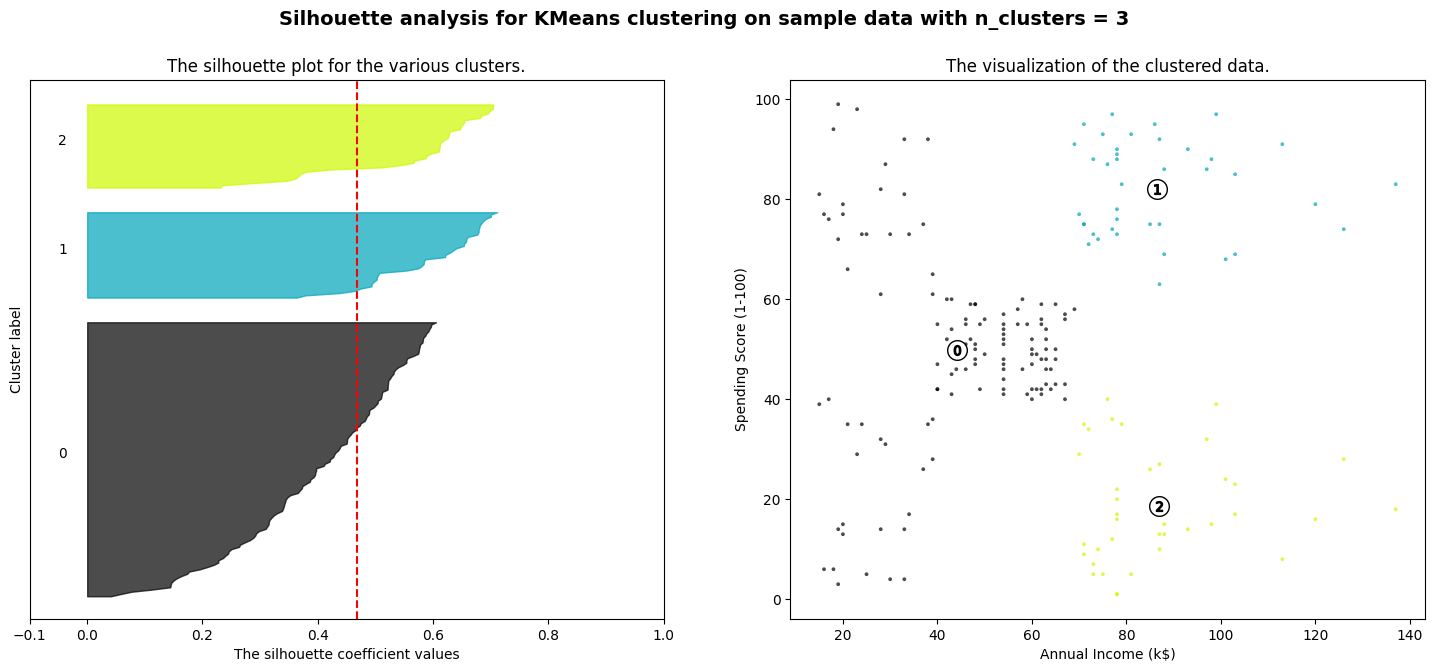

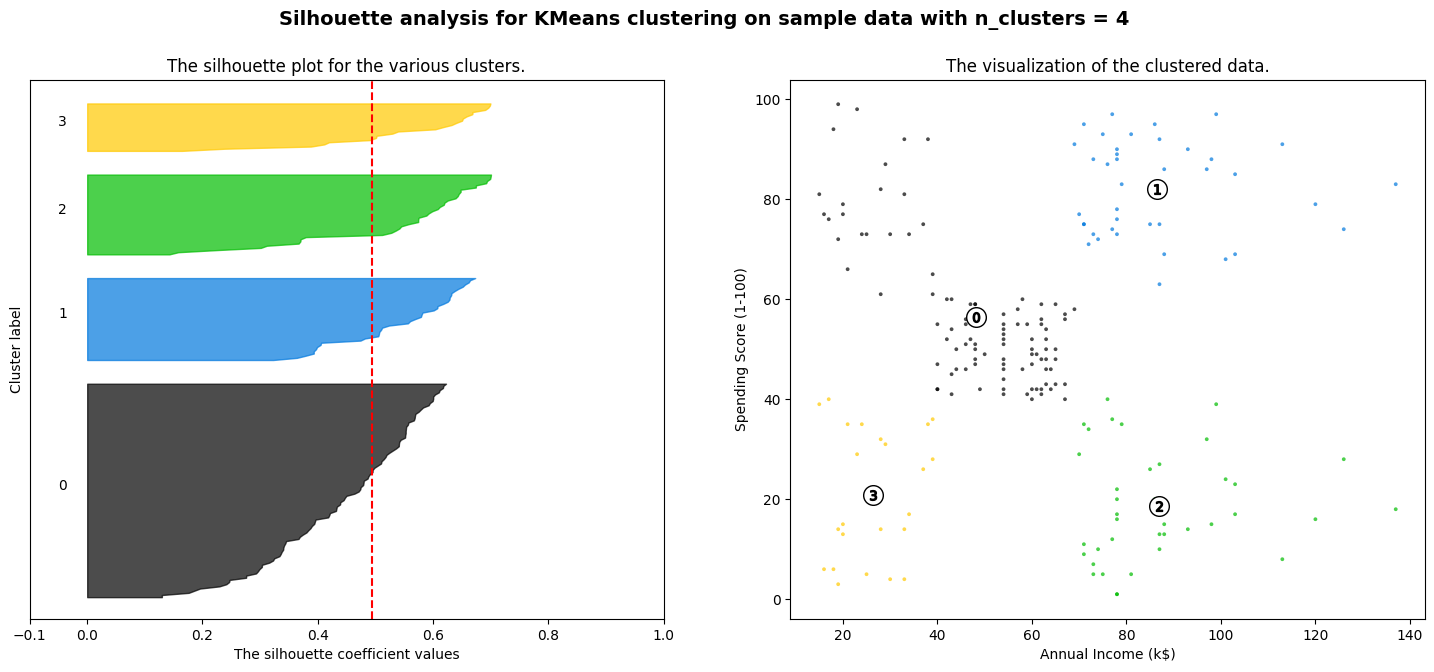

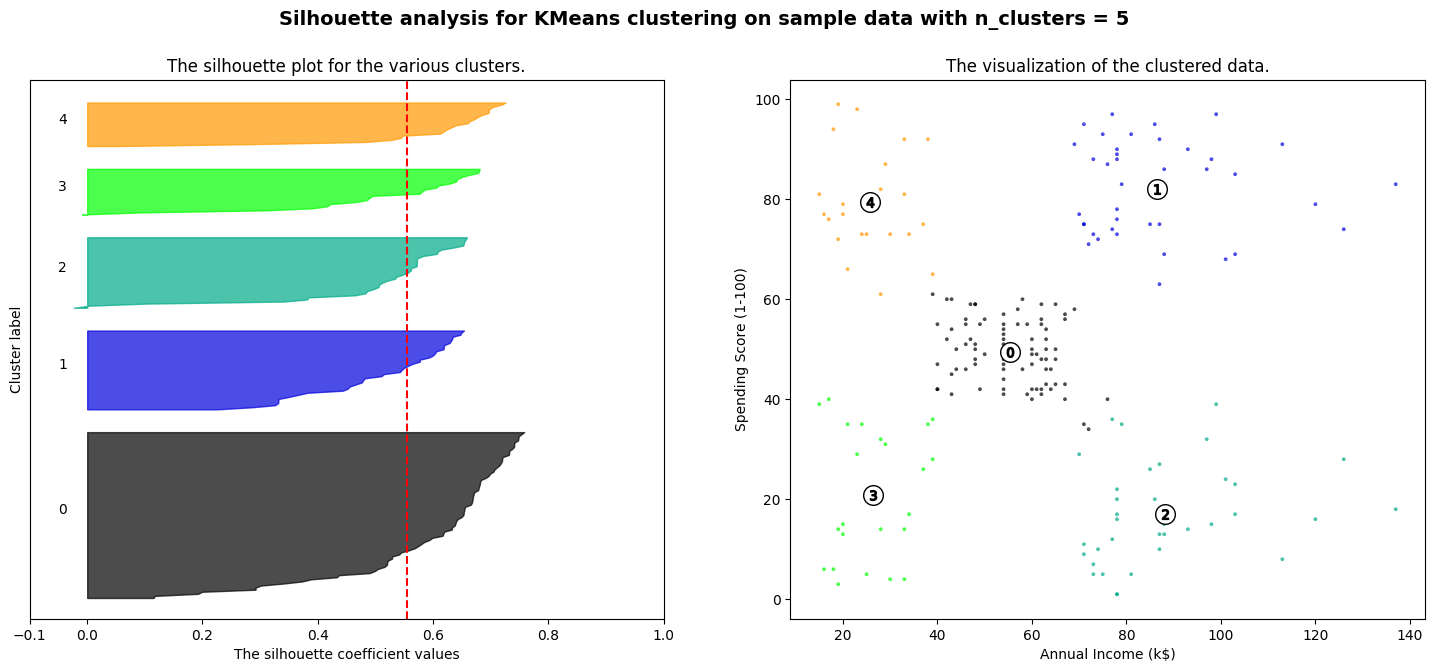

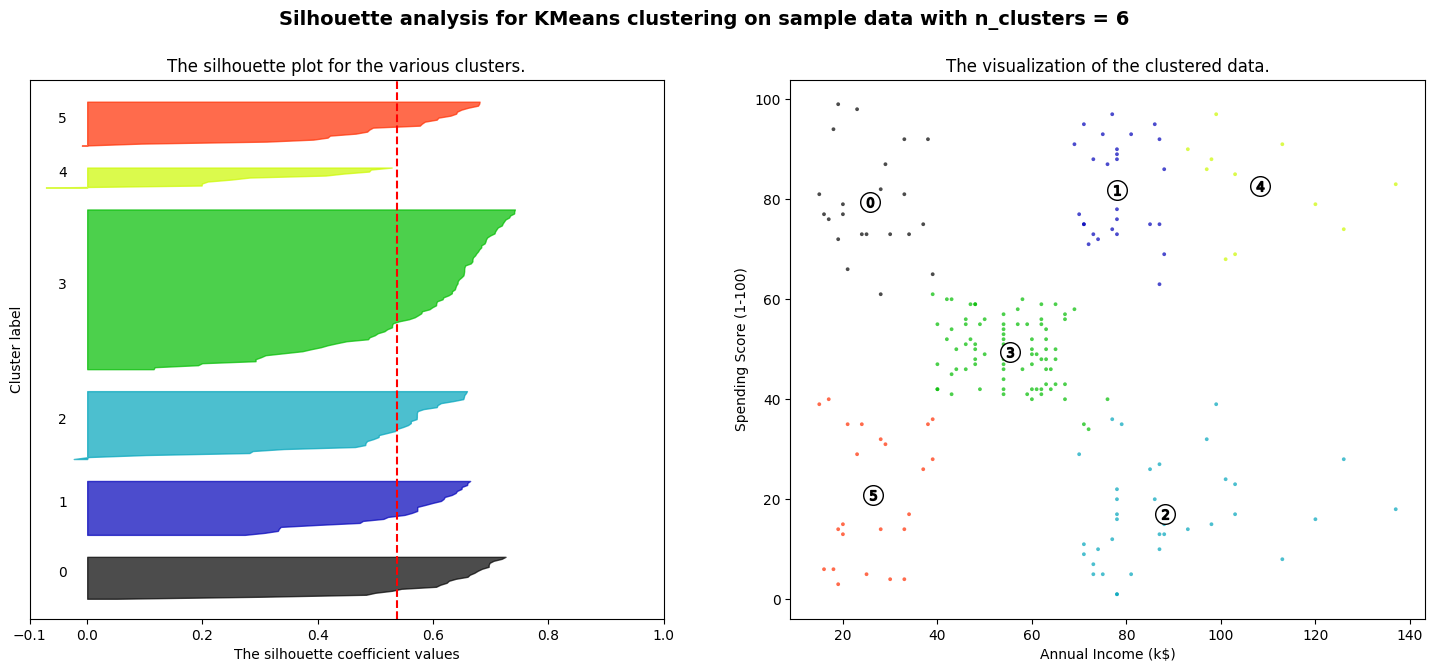

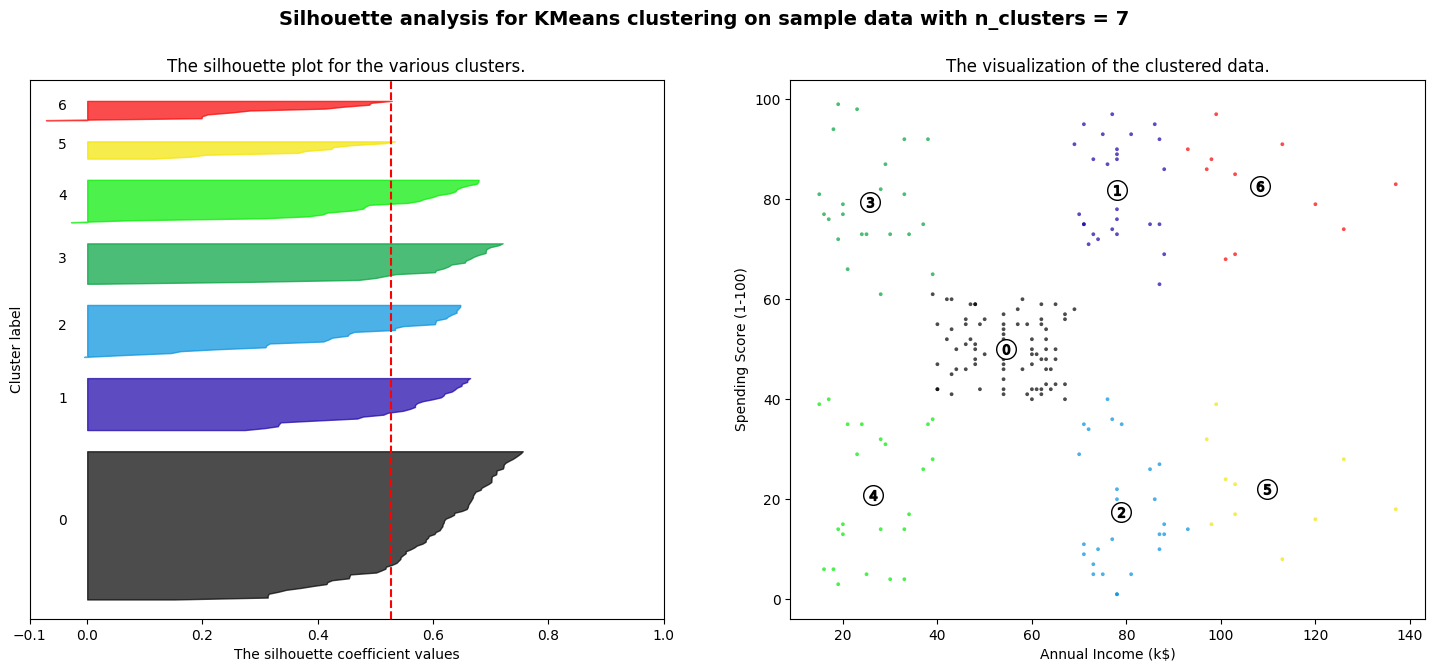

In [21]:
X = df[["Annual Income (k$)", "Spending Score (1-100)"]].values
silhouette_analysis(X, "Annual Income (k$)", "Spending Score (1-100)")

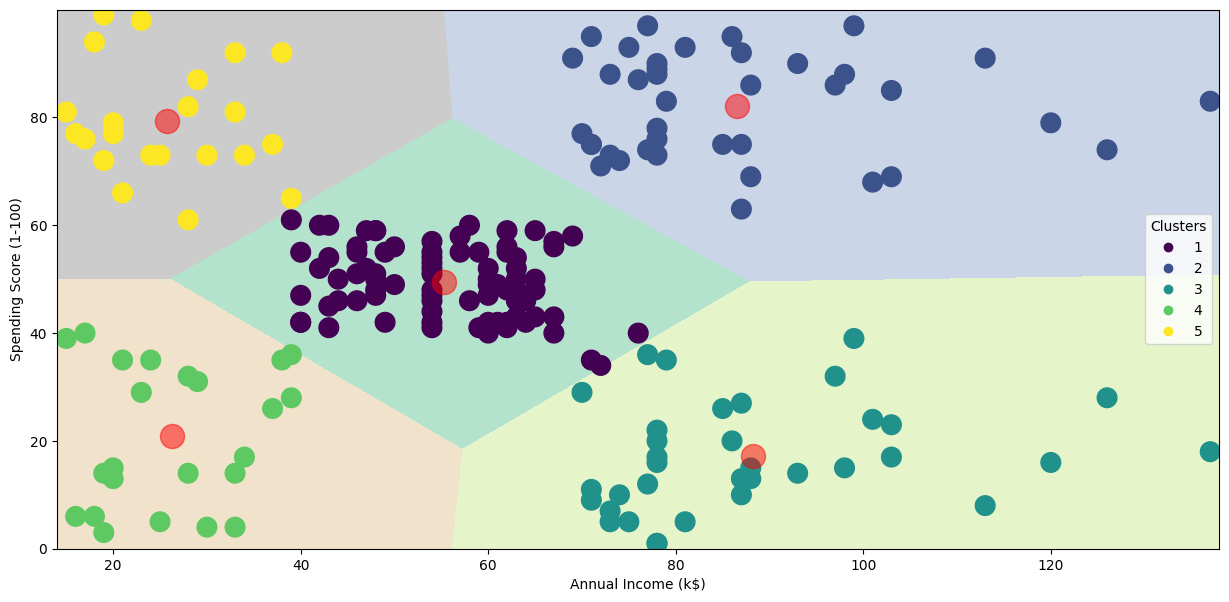

In [22]:
visualize_segmentation(X, 5, "Annual Income (k$)", "Spending Score (1-100)")

Cluster 1 (Purple Colour): Average in terms of earning and spending

Cluster 2 (Blue Colour): Earning high and also spending high [TARGET]

Cluster 3 (Cyan Colour): Earning high but spending less

Cluster 4 (Green Colour): Earning less and also spending less

Cluster 5 (Yellow Colour): Earning less but spending more

#### Segmentation using Age , Annual Income and Spending Score

In [23]:
X = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].values
for n_clusters in list(range(2, 8)):
    clusterer = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, max_iter=300, tol=0.0001, random_state=0, algorithm="elkan")
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.293166070535953
For n_clusters = 3 The average silhouette_score is : 0.3839349967742105
For n_clusters = 4 The average silhouette_score is : 0.40546302077733304
For n_clusters = 5 The average silhouette_score is : 0.44428597560893024
For n_clusters = 6 The average silhouette_score is : 0.4523443947724053
For n_clusters = 7 The average silhouette_score is : 0.43978902692261157


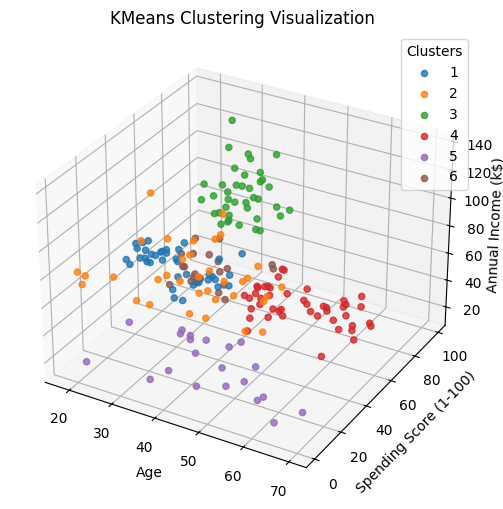

In [24]:
algorithm = KMeans(n_clusters=6, init="k-means++", n_init=10, max_iter=300, tol=0.0001, random_state=0, algorithm="elkan")
algorithm.fit(X)
labels = algorithm.labels_ + 1
df["label"] = labels
fig = plt.figure(figsize=(6, 20))
ax = fig.add_subplot(111, projection='3d')
for cluster_label in range(len(np.unique(labels))):
    cluster_data = df[df["label"] == cluster_label + 1]
    ax.scatter(cluster_data["Age"], cluster_data["Spending Score (1-100)"], cluster_data["Annual Income (k$)"], label=cluster_label + 1, s=20, alpha=0.8)
ax.set_xlabel("Age")
ax.set_ylabel("Spending Score (1-100)")
ax.set_zlabel("Annual Income (k$)", labelpad=0)
ax.set_title("KMeans Clustering Visualization")
ax.legend(title="Clusters")
plt.show()

In [25]:
trace = go.Scatter3d(
    x=df["Age"],
    y=df["Spending Score (1-100)"],
    z=df["Annual Income (k$)"],
    mode="markers",
    marker=dict(
        color=df["label"],
        size=20,
        line=dict(
            color=df["label"],
            width=12
        ),
        opacity=0.8
    )
)
layout = go.Layout(
    title="Clusters",
    scene=dict(
        xaxis=dict(title="Age"),
        yaxis=dict(title="Spending Score"),
        zaxis=dict(title="Annual Income")
    ),
    margin=dict(t=50, b=30)
)

fig = go.Figure(data=[trace], layout=layout)
pyo.iplot(fig)

In [26]:
df["label"].value_counts()

label
4    45
3    39
1    38
2    35
6    22
5    21
Name: count, dtype: int64